In [93]:
import numpy as np
import copy
import matplotlib.pyplot as plt
import h5py
from PIL import Image

In [94]:
def openH5(filename):
    with h5py.File(filename, "r") as f:
        # List all groups
        print("Keys: %s" % f.keys())
        # Get the data
        header = list(f.keys())
        classes = f[header[0]]
        x = f[header[1]]
        y = f[header[2]]
        classes = np.array(classes)
        x = np.array(x)
        y = np.array(y)
        f.close()
    return classes, header, x, y

In [95]:
test_classes, test_header, test_set_x, test_set_y = openH5("test_catvnoncat.h5")
train_classes, train_header, train_set_x, train_set_y = openH5("train_catvnoncat.h5")

Keys: <KeysViewHDF5 ['list_classes', 'test_set_x', 'test_set_y']>
Keys: <KeysViewHDF5 ['list_classes', 'train_set_x', 'train_set_y']>


y = 1, it's a 'cat' picture.
total number of train_set_x: 209
total number of train_set_y: 209


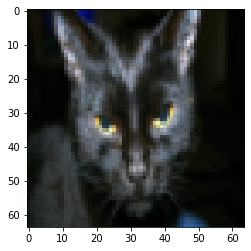

In [96]:
index = 25
plt.imshow(train_set_x[index])
print("y = " + str(train_set_y[index]) + ", it's a '" + train_classes[np.squeeze(train_set_y[index])].decode(
    "utf-8") + "' picture.")
print("total number of " + str(train_header[1]) + ": " + str(train_set_x.shape[0]))
print("total number of " + str(train_header[2]) + ": " + str(train_set_y.shape[0]))

In [97]:
train_set_y = train_set_y.reshape(-1,1).T
test_set_y = test_set_y.reshape(-1,1).T

In [98]:
m_train = train_set_y.shape[1]
m_test = test_set_y.shape[1]
num_px = train_set_x.shape[1]

print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_set_x shape: " + str(train_set_x.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x shape: " + str(test_set_x.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

Number of training examples: m_train = 209
Number of testing examples: m_test = 50
Height/Width of each image: num_px = 64
Each image is of size: (64, 64, 3)
train_set_x shape: (209, 64, 64, 3)
train_set_y shape: (1, 209)
test_set_x shape: (50, 64, 64, 3)
test_set_y shape: (1, 50)


In [99]:
train_set_x_flatten = train_set_x.reshape(train_set_x.shape[0],-1).T
test_set_x_flatten = test_set_x.reshape(test_set_x.shape[0],-1).T

In [100]:
assert np.alltrue(train_set_x_flatten[0:10, 1] == [196, 192, 190, 193, 186, 182, 188, 179, 174, 213]), "Wrong solution. Use (X.shape[0], -1).T."
assert np.alltrue(test_set_x_flatten[0:10, 1] == [115, 110, 111, 137, 129, 129, 155, 146, 145, 159]), "Wrong solution. Use (X.shape[0], -1).T."

print ("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

train_set_x_flatten shape: (12288, 209)
train_set_y shape: (1, 209)
test_set_x_flatten shape: (12288, 50)
test_set_y shape: (1, 50)


In [101]:
train_set_x = train_set_x_flatten / 255
test_set_x = test_set_x_flatten / 255

In [102]:
def sigmoid(z):
    s = 1 / (1 + np.exp(-z))
    return s

In [103]:
def initialize_with_zeros(dim):
    w = np.zeros([dim,1])
    b = 0

    assert(w.shape == (dim, 1))
    assert(isinstance(b, float) or isinstance(b, int))
    
    return w, b

In [104]:
def propagate(w, b, X, Y):
    
    m = X.shape[1]
    
    A = sigmoid(np.dot(w.T, X) + b)
    cost = (-1 / m) * np.sum(Y * np.log(A) + (1 - Y) * (np.log(1 - A)))                              # compute cost
    
    dw = (1 / m) * np.dot(X, (A - Y).T)
    db = (1 / m) * np.sum(A - Y)

    cost = np.squeeze(np.array(cost))

    grads = {"dw": dw,
             "db": db}
    
    return grads, cost

In [105]:
def optimize(w, b, X, Y, num_iterations=100, learning_rate=0.009, print_cost=False):
    
    w = copy.deepcopy(w)
    b = copy.deepcopy(b)
    
    costs = []
    
    for i in range(num_iterations):
        grads, cost = propagate(w, b, X, Y)
        dw = grads["dw"]
        db = grads["db"]
        w = w - learning_rate * dw
        b = b - learning_rate * db
        
        if i % 100 == 0:
            costs.append(cost)
        
            # Print the cost every 100 training iterations
            if print_cost:
                print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

In [106]:
def predict(w, b, X):
    m = X.shape[1]
    Y_prediction = np.zeros((1, m))
    w = w.reshape(X.shape[0], 1)
    A = sigmoid(np.dot(w.T, X) + b)
    for i in range(A.shape[1]):
        Y_prediction[0, i] = 1 if A[0, i] > 0.5 else 0
    
    return Y_prediction

In [108]:
def model(X_train, Y_train, X_test, Y_test, num_iterations=2000, learning_rate=0.5, print_cost=False):
   
    w, b = initialize_with_zeros(X_train.shape[0])
    parameters, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)
    w = parameters["w"]
    b = parameters["b"]
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)

    # Print train/test Errors
    if print_cost:
        print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
        print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

In [109]:
logistic_regression_model = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations=3000, learning_rate=0.005, print_cost=True)

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.584508
Cost after iteration 200: 0.466949
Cost after iteration 300: 0.376007
Cost after iteration 400: 0.331463
Cost after iteration 500: 0.303273
Cost after iteration 600: 0.279880
Cost after iteration 700: 0.260042
Cost after iteration 800: 0.242941
Cost after iteration 900: 0.228004
Cost after iteration 1000: 0.214820
Cost after iteration 1100: 0.203078
Cost after iteration 1200: 0.192544
Cost after iteration 1300: 0.183033
Cost after iteration 1400: 0.174399
Cost after iteration 1500: 0.166521
Cost after iteration 1600: 0.159305
Cost after iteration 1700: 0.152667
Cost after iteration 1800: 0.146542
Cost after iteration 1900: 0.140872
Cost after iteration 2000: 0.135608
Cost after iteration 2100: 0.130708
Cost after iteration 2200: 0.126137
Cost after iteration 2300: 0.121861
Cost after iteration 2400: 0.117855
Cost after iteration 2500: 0.114093
Cost after iteration 2600: 0.110554
Cost after iteration 2700: 0.107219
Cost

y = 1, you predicted that it is a "non-cat" picture.


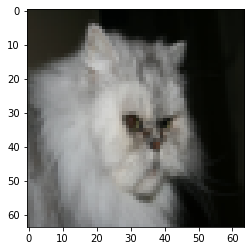

In [110]:
# Example of a picture that was wrongly classified.
index = 10
plt.imshow(test_set_x[:, index].reshape((num_px, num_px, 3)))
print ("y = " + str(test_set_y[0,index]) + ", you predicted that it is a \"" + test_classes[int(logistic_regression_model['Y_prediction_test'][0,index])].decode("utf-8") +  "\" picture.")

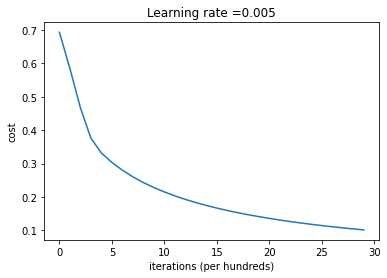

In [111]:
# Plot learning curve (with costs)
costs = np.squeeze(logistic_regression_model['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(logistic_regression_model["learning_rate"]))
plt.show()

Training a model with learning rate: 0.01
Cost after iteration 0: 0.693147
Cost after iteration 100: 0.823921
Cost after iteration 200: 0.418944
Cost after iteration 300: 0.617350
Cost after iteration 400: 0.522116
Cost after iteration 500: 0.387709
Cost after iteration 600: 0.236254
Cost after iteration 700: 0.154222
Cost after iteration 800: 0.135328
Cost after iteration 900: 0.124971
Cost after iteration 1000: 0.116478
Cost after iteration 1100: 0.109193
Cost after iteration 1200: 0.102804
Cost after iteration 1300: 0.097130
Cost after iteration 1400: 0.092043
train accuracy: 99.52153110047847 %
test accuracy: 68.0 %

-------------------------------------------------------

Training a model with learning rate: 0.001
Cost after iteration 0: 0.693147
Cost after iteration 100: 0.591289
Cost after iteration 200: 0.555796
Cost after iteration 300: 0.528977
Cost after iteration 400: 0.506881
Cost after iteration 500: 0.487880
Cost after iteration 600: 0.471108
Cost after iteration 700: 0.

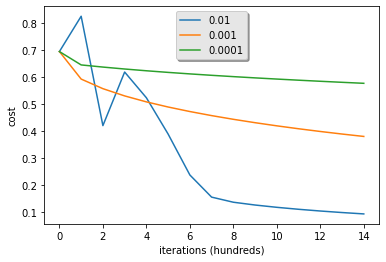

In [112]:
learning_rates = [0.01, 0.001, 0.0001]
models = {}

for lr in learning_rates:
    print ("Training a model with learning rate: " + str(lr))
    models[str(lr)] = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations=1500, learning_rate=lr, print_cost=True)
    print ('\n' + "-------------------------------------------------------" + '\n')

for lr in learning_rates:
    plt.plot(np.squeeze(models[str(lr)]["costs"]), label=str(models[str(lr)]["learning_rate"]))

plt.ylabel('cost')
plt.xlabel('iterations (hundreds)')

legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()

y = 0.0, your algorithm predicts a "non-cat" picture.


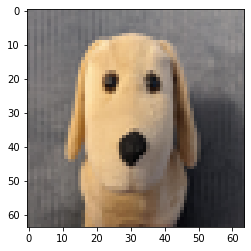

In [113]:
my_image = "nell.jpg"   

fname = my_image
image = np.array(Image.open(fname).resize((num_px, num_px)))
plt.imshow(image)
image = image / 255.
image = image.reshape((1, num_px * num_px * 3)).T
my_predicted_image = predict(logistic_regression_model["w"], logistic_regression_model["b"], image)

print("y = " + str(np.squeeze(my_predicted_image)) + ", your algorithm predicts a \"" + test_classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")

y = 1.0, your algorithm predicts a "cat" picture.


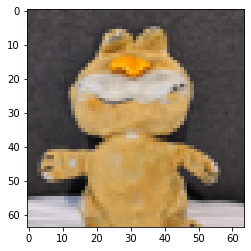

In [114]:
my_image = "bao.jpg"   

fname = my_image
image = np.array(Image.open(fname).resize((num_px, num_px)))
plt.imshow(image)
image = image / 255.
image = image.reshape((1, num_px * num_px * 3)).T
my_predicted_image = predict(logistic_regression_model["w"], logistic_regression_model["b"], image)

print("y = " + str(np.squeeze(my_predicted_image)) + ", your algorithm predicts a \"" + test_classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")

y = 1.0, your algorithm predicts a "cat" picture.


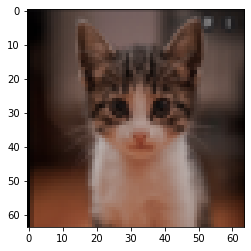

In [115]:
my_image = "my_image.jpg"   

fname = my_image
image = np.array(Image.open(fname).resize((num_px, num_px)))
plt.imshow(image)
image = image / 255.
image = image.reshape((1, num_px * num_px * 3)).T
my_predicted_image = predict(logistic_regression_model["w"], logistic_regression_model["b"], image)

print("y = " + str(np.squeeze(my_predicted_image)) + ", your algorithm predicts a \"" + test_classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")